In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from utils import generate_distance_features
# from utils.LGBM.lgbm_model import train_lgbm_model, evaluate_model
# Update the imports section

# from utils.LGBM.lgbm_utils import (
#     generate_distance_features, 
#     reduce_features_with_pca, 
#     evaluate_model,
#     infer_on_new_data_with_pca
# )
# from utils.DNN_.siamese_utils

import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

def get_env_var(name: str, var_type=str):
    """Get environment variable with type conversion and error checking."""
    value = os.getenv(name)
    if value is None:
        raise ValueError(f"Environment variable {name} is not set")
    return var_type(value)

# Configuration from environment variables
# RANDOM_SEED = get_env_var('RANDOM_SEED', int)
TEST_SIZE = 0.2
PCA_N_COMPONENTS = 4
DATA_PATH = os.path.join(
    get_env_var('DATA_DIR'),
    get_env_var('COMPANY_MATCHING_DATA')
)

# LGBM parameters
lgbm_params = {
    'num_leaves': get_env_var('LGBM_NUM_LEAVES', int),
    'max_depth': get_env_var('LGBM_MAX_DEPTH', int),
    'learning_rate': get_env_var('LGBM_LEARNING_RATE', float),
    'n_estimators': get_env_var('LGBM_N_ESTIMATORS', int)
}

# Second cell - Load data
df = pd.read_pickle(DATA_PATH)

ValueError: Environment variable DATA_DIR is not set

In [ ]:
# ---
# # 1. Load and Explore the Dataset
# ---
# Load the dataset
df = pd.read_pickle("data/BinaryLabelled_CompanyMatching_Data.pkl")
print("Dataset Sample:")
print(df.head())

# ---
# # 2. Feature Engineering: Generate String Distance Metrics
# ---
df, feature_cols = generate_distance_features(df, col1='Company1', col2='Company2')
print("Dataset with Features:")
print(df.head())



Dataset Sample:
                               Company1                             Company2  \
0          Abb Power Grids Australia Pl            Abb Power Grids Australia   
1           Essential Brands Franchisee                         The Branders   
2  Element Fleet Management Corporation             Element Fleet Management   
3                        Thales Sa Eur3            Foreshore Townhomes North   
4     Goldman Sachs Step Compli Gbp Ecd  Goldman Sachs Step Complian Gbp Ecd   

   Label  
0      1  
1      0  
2      1  
3      0  
4      1  
Dataset with Features:
                               Company1                             Company2  \
0          Abb Power Grids Australia Pl            Abb Power Grids Australia   
1           Essential Brands Franchisee                         The Branders   
2  Element Fleet Management Corporation             Element Fleet Management   
3                        Thales Sa Eur3            Foreshore Townhomes North   
4     Goldman 

In [3]:
distance_features = df[[col for col in df.columns[3:-2]]].columns
distance_features

Index(['levenshtein', 'jaccard', 'cosine', 'hamming'], dtype='object')

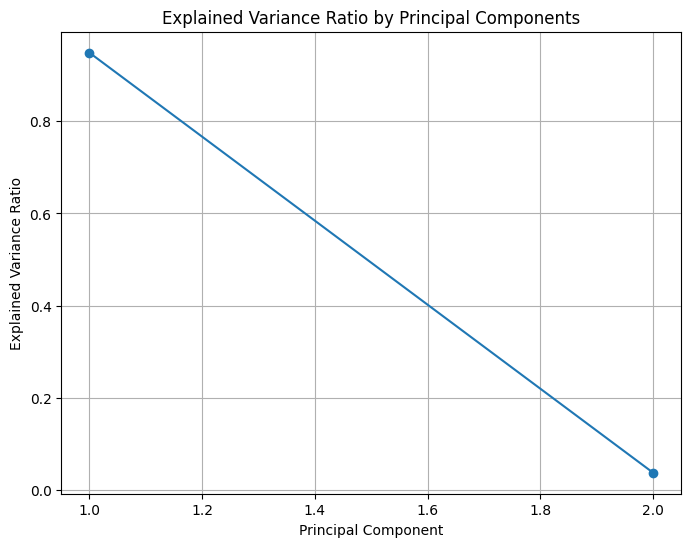

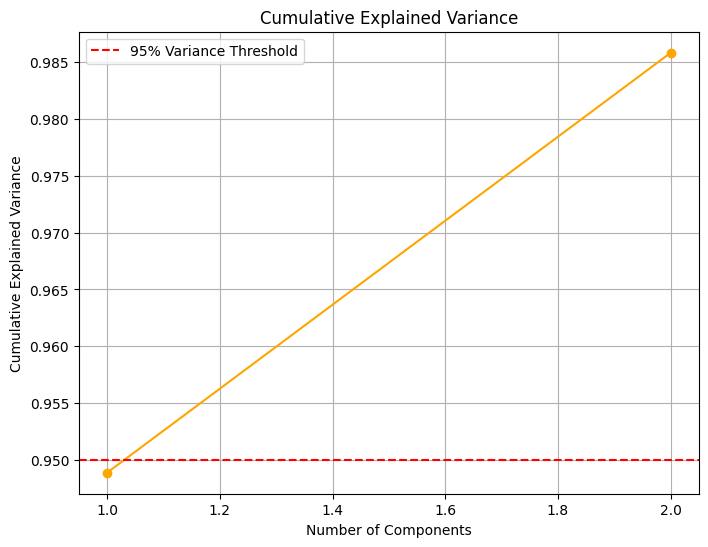

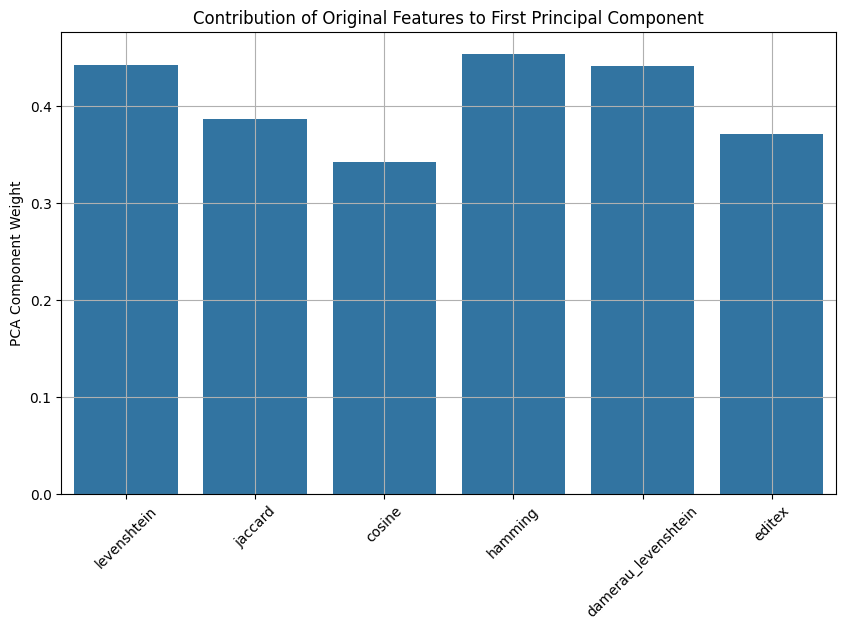

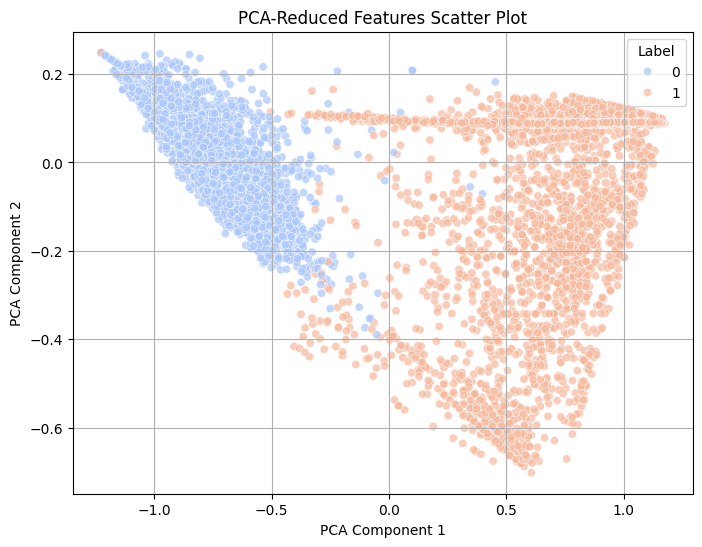

In [6]:
# ---
# # 3. PCA Analysis: Dimensionality Reduction
# ---
# 3.0. PCA
X_reduced, pca = reduce_features_with_pca(df, feature_cols, n_components=2)
df['pca_1'] = X_reduced[:, 0]
df['pca_2'] = X_reduced[:, 1]

# ---
# ## 3.1. Visualise Explained Variance
# ---
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

# Cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='orange')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()

# ---
# ## 3.2. Feature Contributions to PCA Components
# ---
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_cols, y=pca.components_[0])
plt.title('Contribution of Original Features to First Principal Component')
plt.ylabel('PCA Component Weight')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# ---
# ## 3.3. Visualise Data in PCA-Reduced Space
# ---
# Add the first two PCA components to the DataFrame

# Scatter plot of PCA-reduced features
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='Label', data=df, palette='coolwarm', alpha=0.7)
plt.title('PCA-Reduced Features Scatter Plot')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Label', loc='upper right')
plt.grid()
plt.show()


In [7]:

# ---
# # 4. Train-Test Split
# ---
# Prepare training and test data
X = df[['pca_1', 'pca_2']]
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---
# # 5. Train the LGBM Model
# ---
model = train_lgbm_model(X_train, y_train, X_test, y_test)

# ---
# # 6. Evaluate the Model
# ---
metrics = evaluate_model(model, X_test, y_test)
print("Model Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")




[LightGBM] [Info] Number of positive: 5950, number of negative: 5906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 11856, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501856 -> initscore=0.007422
[LightGBM] [Info] Start training from score 0.007422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model Evaluation Metrics:
Accuracy: 0.9966
Precision: 0.9966
Recall: 0.9966
F1_score: 0.9966
Roc_auc: 0.9993


In [25]:
# Update the inference part
new_data = pd.DataFrame({
    'Company1': ['Delta Airlines', 'Apple Inc', 'Microsoft','Officeworks Wagga','fair Supply', 'Quantas'],
    'Company2': ['Delta Ag', 'Apple', 'Microsoft Corporation','Officeworks Homebush','FairSupply','Quantas #123']
})

# Run inference with the updated function
results = infer_on_new_data_with_pca(
    model, 
    new_data, 
    original_df=df,  # Add this parameter
    pca=pca, 
    col1='Company1', 
    col2='Company2'
)

# Display results
print("Inference Results:")
print(results)


Inference Results:
            Company1               Company2  levenshtein   jaccard    cosine  \
0     Delta Airlines               Delta Ag     0.500000  0.466667  0.661438   
1          Apple Inc                  Apple     0.555556  0.555556  0.745356   
2          Microsoft  Microsoft Corporation     0.428571  0.428571  0.654654   
3  Officeworks Wagga   Officeworks Homebush     0.600000  0.480000  0.650791   
4        fair Supply             FairSupply     0.818182  0.750000  0.858116   
5            Quantas           Quantas #123     0.583333  0.583333  0.763763   

    hamming  damerau_levenshtein    editex  prediction  prediction_proba  
0  0.500000             0.500000  0.571429           0          0.257403  
1  0.555556             0.555556  0.555556           1          0.999960  
2  0.428571             0.428571  0.452381           1          0.997102  
3  0.600000             0.600000  0.675000           1          0.999796  
4  0.363636             0.818182  0.909091   

In [ ]:
# ---
# # 7. Save the Model
# ---
save_model(model, 'lgbm_company_matching.pkl')
print("Model saved as 'lgbm_company_matching.pkl'")